In [2]:
import pandas as pd
import numpy as np
import os
import yfinance as yf
import itertools
import warnings
import functions as func
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import shapiro

In [3]:
DATA_PATH = "avgo_data.json"

if os.path.exists(DATA_PATH):
    
    with open(DATA_PATH) as f:
        avgo_hist = pd.read_json(DATA_PATH)
else:
    avgo = yf.Ticker("AVGO")
    avgo_hist = avgo.history(period="max")

    avgo_hist.to_json(DATA_PATH)

In [4]:
avgo_hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2009-08-06 04:00:00,11.835759,12.129860,11.161480,11.606217,24197800,0.0,0
2009-08-07 04:00:00,11.584700,12.022265,11.498623,11.785550,2454300,0.0,0
2009-08-10 04:00:00,11.929010,11.929010,11.197346,11.455581,2421000,0.0,0
2009-08-11 04:00:00,11.462755,11.477102,11.118443,11.240387,2305400,0.0,0
2009-08-12 04:00:00,11.584701,11.620568,11.233215,11.477103,1451300,0.0,0
...,...,...,...,...,...,...,...
2024-04-09 04:00:00,1357.369995,1359.479980,1308.640015,1334.079956,1800800,0.0,0
2024-04-10 04:00:00,1323.000000,1335.750000,1315.479980,1322.369995,1746700,0.0,0
2024-04-11 04:00:00,1332.680054,1391.869995,1323.650024,1382.459961,3171300,0.0,0
2024-04-12 04:00:00,1352.010010,1366.510010,1336.619995,1344.069946,2778000,0.0,0


<Axes: >

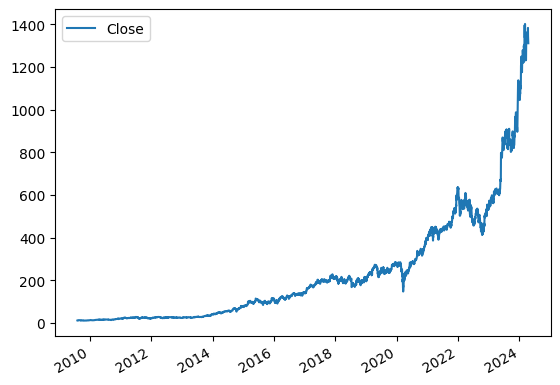

In [5]:
avgo_hist.plot.line(y="Close", use_index=True)

In [6]:
df_avgo = func.calculate_technical_indicators(avgo_hist)

In [7]:
df_avgo_clean = df_avgo.dropna(subset=['rsi'])
df_avgo_clean = df_avgo_clean.drop(columns=['Dividends', 'Stock Splits'])
df_avgo_clean.index = pd.to_datetime(df_avgo_clean.index)
df_avgo_clean

,Open,High,Low,Close,Volume,ema_12,ema_26,macd_line,macd_signal,rsi
2009-08-25 04:00:00,12.660679,12.840008,12.588946,12.804143,530800,12.300094,12.008355,0.291740,0.170403,67.216597
2009-08-26 04:00:00,12.689372,12.804143,12.302019,12.804143,708600,12.377640,12.067302,0.310338,0.198390,67.216597
2009-08-27 04:00:00,12.804145,13.062379,12.588948,13.026513,1161100,12.477467,12.138355,0.339112,0.226535,67.617194
2009-08-28 04:00:00,12.983473,13.629060,12.911741,13.248880,1295000,12.596146,12.220616,0.375530,0.256334,76.260677
2009-08-31 04:00:00,13.162802,13.198667,12.775449,13.055204,1004800,12.666770,12.282437,0.384333,0.281934,76.744321
...,...,...,...,...,...,...,...,...,...,...
2024-04-09 04:00:00,1357.369995,1359.479980,1308.640015,1334.079956,1800800,1330.019876,1313.346195,16.673681,17.601892,67.119480
2024-04-10 04:00:00,1323.000000,1335.750000,1315.479980,1322.369995,1746700,1328.842971,1314.014625,14.828347,17.047183,58.769241
2024-04-11 04:00:00,1332.680054,1391.869995,1323.650024,1382.459961,3171300,1337.091739,1319.084649,18.007090,17.239164,56.824296
2024-04-12 04:00:00,1352.010010,1366.510010,1336.619995,1344.069946,2778000,1338.165309,1320.935412,17.229897,17.237311,48.353184


## Checking for stationarity

In [8]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

stat_test = check_stationarity(df_avgo_clean['Close'])

The series is NOT stationary


<Axes: >

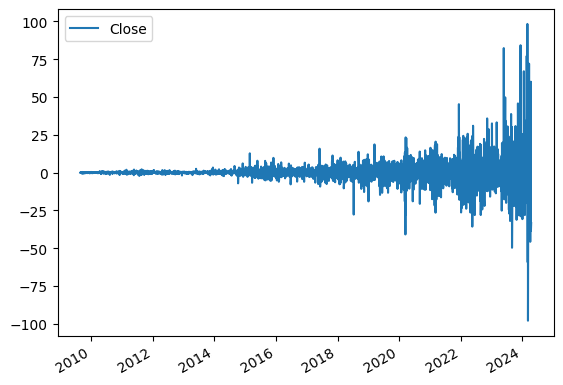

In [9]:
df_close = df_avgo_clean[['Close']].copy()
df_diff = df_close.diff()
df_diff.plot()

In [10]:
df_diff = df_diff.drop(df_diff.index[0])
nan_count = df_diff.isna().sum().sum()
inf_count = np.isinf(df_diff).sum().sum()

print("Number of NaN values in the DataFrame:", nan_count)
print("Number of infinite values in the DataFrame:", inf_count)

Number of NaN values in the DataFrame: 0
Number of infinite values in the DataFrame: 0


In [11]:
def perform_adf_test(ts):
    adf_result = adfuller(ts)
    return adf_result

adf_result = perform_adf_test(df_diff)
print("ADF test statistics:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical values:", adf_result[4])

ADF test statistics: -8.535667807728588
p-value: 1.0096206893395444e-13
Critical values: {'1%': -3.432140886649974, '5%': -2.8623313141020867, '10%': -2.5671912284473395}


The set seems to be stationary now, however a seccond diff might be needed. We will see this during the acf and pacf plotting.

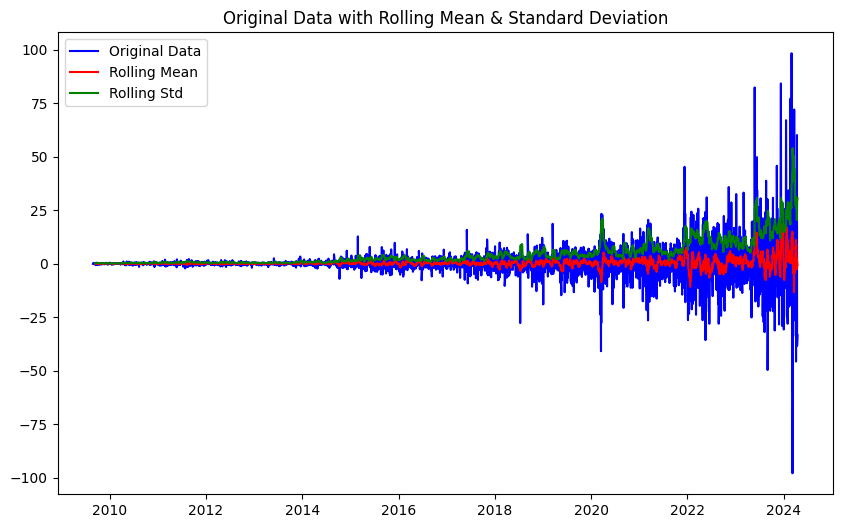

In [12]:
ts = df_diff

plt.figure(figsize=(10, 6))
plt.plot(ts, color='blue', label='Original Data')

rolling_mean = ts.rolling(window=12).mean()
rolling_std = ts.rolling(window=12).std()

plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='green', label='Rolling Std')
plt.title('Original Data with Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

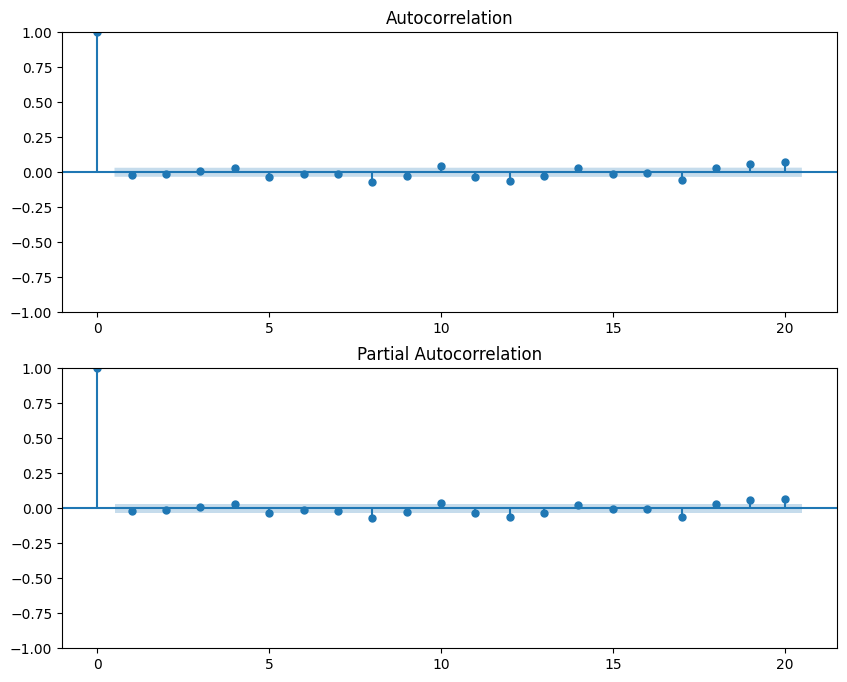

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(ts, ax=axes[0], lags=20)
plot_pacf(ts, ax=axes[1], lags=20)
plt.show()

In [15]:
df_close.index = pd.to_datetime(df_close.index)
start_date = pd.Timestamp('2020-01-22 05:00:00')
avgo_2020 = df_close[df_close.index >= start_date]

In [17]:
avgo_2020

,Close
2020-01-22 05:00:00,274.176270
2020-01-23 05:00:00,280.028198
2020-01-24 05:00:00,283.839020
2020-01-27 05:00:00,270.724579
2020-01-28 05:00:00,278.854340
...,...
2024-04-09 04:00:00,1334.079956
2024-04-10 04:00:00,1322.369995
2024-04-11 04:00:00,1382.459961
2024-04-12 04:00:00,1344.069946


In [18]:
avgo_2020.index = pd.to_datetime(avgo_2020.index)
model = auto_arima(df_close, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.59 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=28112.510, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=27025.872, Time=0.16 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=28110.512, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=26551.488, Time=0.26 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=26262.472, Time=0.67 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=26165.191, Time=0.94 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=26072.792, Time=1.18 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=5.99 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.29 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=26070.796, Time=0.68 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=26163.195, Time=0.55 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=2.31 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Ti

In [19]:
print(model.summary())

forecast_steps = 5
forecast = model.predict(n_periods=forecast_steps)
print("Forecasted values:")
print(forecast)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3684
Model:               SARIMAX(5, 2, 0)   Log Likelihood              -13029.398
Date:                Tue, 16 Apr 2024   AIC                          26070.796
Time:                        10:22:07   BIC                          26108.063
Sample:                             0   HQIC                         26084.062
                               - 3684                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8512      0.007   -129.276      0.000      -0.864      -0.838
ar.L2         -0.6944      0.008    -83.057      0.000      -0.711      -0.678
ar.L3         -0.5069      0.008    -63.814      0.0

C:\Users\gijsv\onedrive\documenten\ironhack\final_project\final_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\gijsv\onedrive\documenten\ironhack\final_project\final_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


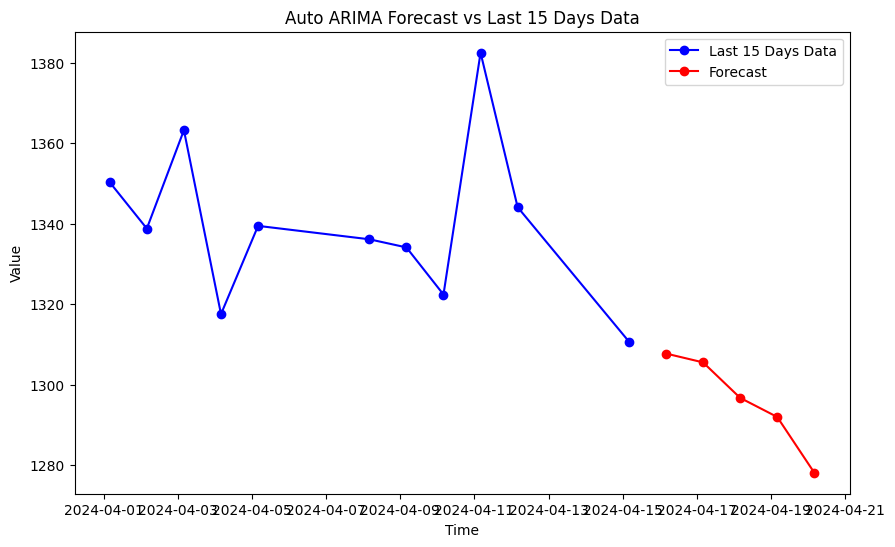

In [20]:
last_15_days_data = df_close[df_close.index >= df_close.index[-1] - pd.Timedelta(days=15)]

forecast_start_date = last_15_days_data.index[-1] + pd.Timedelta(days=1)
forecast_end_date = last_15_days_data.index[-1] + pd.Timedelta(days=len(forecast))
forecast_index = pd.date_range(start=forecast_start_date, periods=len(forecast), freq='D')

plt.figure(figsize=(10, 6))
plt.plot(last_15_days_data.index, last_15_days_data, 'o-', label='Last 15 Days Data', color='blue')
plt.plot(forecast_index, forecast, 'o-', label='Forecast', color='red')
plt.title('Auto ARIMA Forecast vs Last 15 Days Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [21]:
s = 12
model_sarima_12 = auto_arima(df_close, seasonal=True, m=s, max_order=None)

In [22]:
model_sarima_12

ARIMA(order=(5, 2, 0), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [23]:
order = (5, 2, 2)
seasonal_order = (2, 0, 2, 12)
model_sarimax_12 = SARIMAX(df_close, order=order, seasonal_order=seasonal_order)
model_fit_sarima_12 = model_sarimax_12.fit()

forecast_sarima_12 = model_fit_sarima_12.forecast(steps=5)

print("Forecasted values:", forecast_sarima_12)

C:\Users\gijsv\onedrive\documenten\ironhack\final_project\final_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\gijsv\onedrive\documenten\ironhack\final_project\final_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\gijsv\onedrive\documenten\ironhack\final_project\final_venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\gijsv\onedrive\documenten\ironhack\final_project\final_venv\lib\site-packages\statsmodels\base\model.py:607: Convergenc

Forecasted values: 3684    1307.941424
3685    1310.280682
3686    1308.780625
3687    1310.751365
3688    1313.558277
Name: predicted_mean, dtype: float64


C:\Users\gijsv\onedrive\documenten\ironhack\final_project\final_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\gijsv\onedrive\documenten\ironhack\final_project\final_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
